In [2]:
from dotenv import load_dotenv
import os
load_dotenv()  # take environment variables from .env.
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=os.getenv('QISKIT_IBM_TOKEN'))


In [3]:
from qiskit import QuantumCircuit
import qiskit.visualization as qvis

In [4]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])


### Ideal circulit as its simulator based

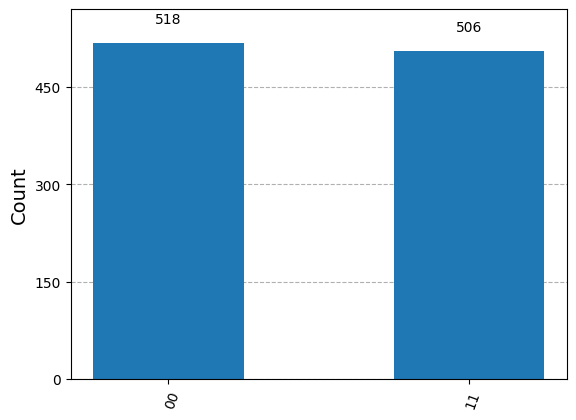

In [5]:
from qiskit_aer import QasmSimulator

v_backend = QasmSimulator()
res = v_backend.run(qc).result().get_counts()

qvis.plot_histogram(res)

### actual hardware

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

ibm_backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(backend=ibm_backend, optimization_level=1)

isa_circuit = pm.run(qc)

sampler = Sampler(mode=ibm_backend)
sampler.options.default_shots = 1024  # Options can be set using auto-complete.
job = sampler.run([isa_circuit])
print(f"Job ID is {job.job_id()}")
job.status()

pub_result = job.result()[0]

Job ID is czkzbbxa980g008hmzdg


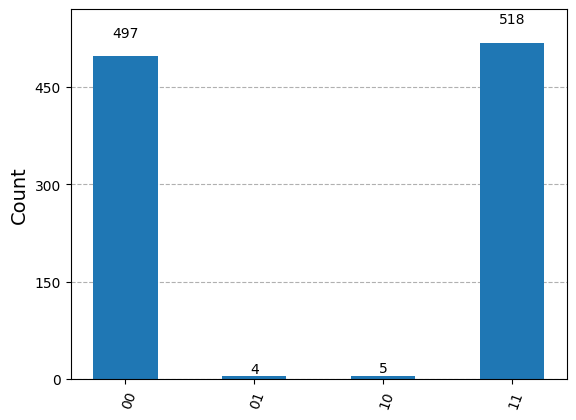

In [15]:
qvis.plot_histogram(pub_result.data["c"].get_counts())

### Now we can replicate the noise in the simulator. 
we get the configuration from real backend and pass the configuration to the simulator.

In [16]:
from qiskit_aer.noise import NoiseModel

n_model = NoiseModel.from_backend(ibm_backend)

coupling_map = ibm_backend.configuration().coupling_map

basis_gates = n_model.basis_gates

In [18]:
res = v_backend.run(qc, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=n_model).result()

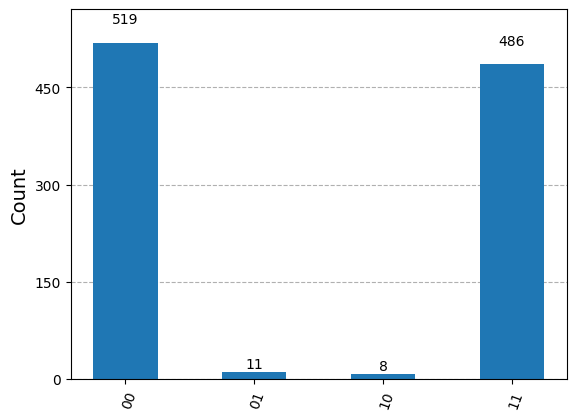

In [19]:
qvis.plot_histogram(res.get_counts())